# Fashion-MNIST with PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

torch.set_printoptions(linewidth=120) # Allows PyTorch to print longer lines (not required)

## Prepare the Data

### ETL Process

To prepare the data, we will use an ETL process:
- **E:** Extract the data from a data-source
- **T:** Transform the data into a desireable format
- **L:** Load the data into a suitable structure for analysis

First, we need to create an instance of the PyTorch dataset class (`torch.utils.data.Dataset`), which is an abstract class for representing a dataset. In practice, we would create a class that extends this class and define methods for `__len__` and `__getitem__`. Since the Fashion-MNIST dataset is built into torchvision, we can simply create a dataset object using the following built-in function.

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data', # The location on disk where the data is located.
    train = True, # If the dataset is the training set
    download = True, # If the data should be downloaded
    transform = transforms.Compose([ # A composition of transformations that should be performed on the dataset elements.
        transforms.ToTensor()
    ])
)

Next, we pass this dataset object to a dataloader class which wraps the dataset and provides access to the underlying data as well as additional functions such as minibatches, shuffling, etc.

In [3]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=100,
    shuffle=True
)

### Exploring the Data

In [4]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
len(train_set)

60000

In [6]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [7]:
train_set.targets.bincount() # Every class has 6000 examples

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

**Note:** If the dataset is unbalanced, the best apprach is to oversample classes that appear less frequently in the training set, so that the neural network trains on each class equally.

In [8]:
sample = next(iter(train_set))

In [9]:
len(sample), type(sample)

(2, tuple)

In [10]:
image, label = sample

In [11]:
image.shape

torch.Size([1, 28, 28])

Label: 9


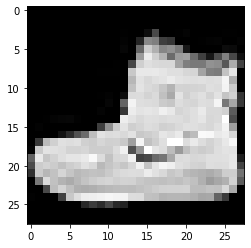

In [12]:
plt.imshow(image.squeeze(), cmap='gray');
print('Label:', label)

In [13]:
batch = next(iter(train_loader))

In [14]:
len(batch), type(batch)

(2, list)

In [15]:
images, labels = batch

In [16]:
images.shape, labels.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [17]:
images[0].shape # First image in the batch

torch.Size([1, 28, 28])

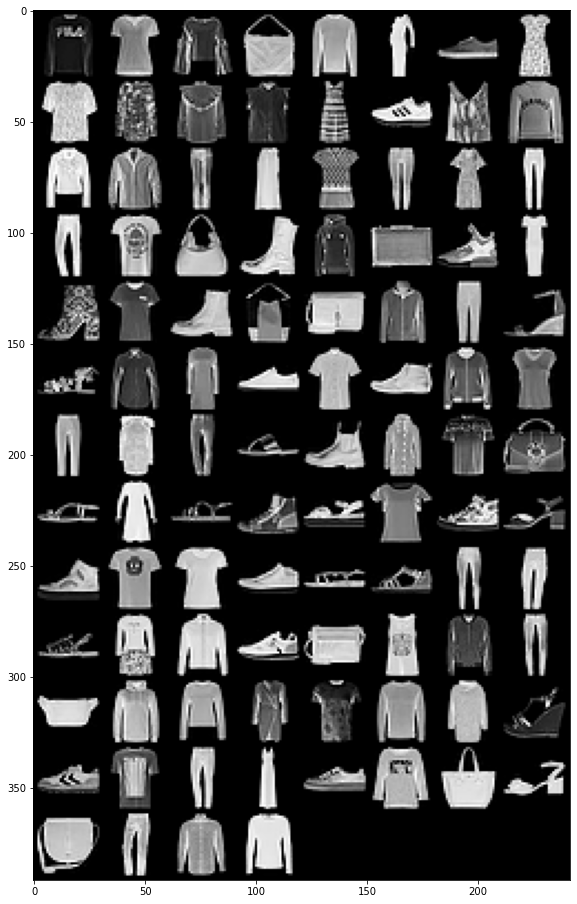

In [18]:
grid = torchvision.utils.make_grid(images, nrows=12)

plt.figure(figsize=(16,16))
plt.imshow(np.transpose(grid, (1,2,0)));

## Build the Model

In [19]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        # PyTorch automatically keeps track of the learnable parameters in layers defined as attributes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # The words linear, dense, and fully connected refer to the same type of layer
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # Conv Layer 1
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # Conv Layer 2
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # FC Layer 3
        t = F.relu(self.fc1(t.reshape(-1, 12*4*4))) # We don't use flatten since it won't work with batches
        
        # FC Layer 4
        t = F.relu(self.fc2(t))
        
        # FC Layer 5
        t = self.out(t) # We don't use softmax since cross-entropy loss implicitly performs softmax
        
        return t

In [20]:
network = Network()
network

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

### Viewing Weight Tensors

In [21]:
network.fc2.weight, network.fc2.bias # Randomly initialized

(Parameter containing:
 tensor([[ 0.0607,  0.0160,  0.0775,  ...,  0.0275, -0.0158, -0.0456],
         [-0.0794, -0.0817, -0.0186,  ..., -0.0808,  0.0400,  0.0873],
         [-0.0143, -0.0435,  0.0875,  ...,  0.0667,  0.0759,  0.0830],
         ...,
         [ 0.0215,  0.0571,  0.0723,  ..., -0.0706,  0.0199, -0.0904],
         [ 0.0558, -0.0528,  0.0275,  ...,  0.0858,  0.0324,  0.0354],
         [-0.0699, -0.0585, -0.0859,  ...,  0.0611, -0.0808, -0.0067]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0530,  0.0190, -0.0051, -0.0151,  0.0447, -0.0211,  0.0679,  0.0442, -0.0596, -0.0793, -0.0420,  0.0575,
          0.0733,  0.0558, -0.0422, -0.0819,  0.0121,  0.0114, -0.0362,  0.0341, -0.0105,  0.0320, -0.0074,  0.0852,
          0.0089,  0.0334, -0.0722,  0.0065, -0.0191,  0.0277, -0.0747, -0.0165,  0.0600,  0.0042, -0.0239,  0.0673,
         -0.0120, -0.0896, -0.0291, -0.0647,  0.0512,  0.0284, -0.0671,  0.0550,  0.0619,  0.0019,  0.0146,  0.0135,
          0.0016,  0.089

In [22]:
network.conv1.weight.shape

torch.Size([6, 1, 5, 5])

In [23]:
network.fc1.weight.shape

torch.Size([120, 192])

In [24]:
for param in network.parameters():
    print(param.shape)

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([12, 6, 5, 5])
torch.Size([12])
torch.Size([120, 192])
torch.Size([120])
torch.Size([60, 120])
torch.Size([60])
torch.Size([10, 60])
torch.Size([10])


In [25]:
for name, param in network.named_parameters():
    print(name, '\t', param.shape)

conv1.weight 	 torch.Size([6, 1, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([12, 6, 5, 5])
conv2.bias 	 torch.Size([12])
fc1.weight 	 torch.Size([120, 192])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([60, 120])
fc2.bias 	 torch.Size([60])
out.weight 	 torch.Size([10, 60])
out.bias 	 torch.Size([10])


### Note on Using `nn module` Layers

In [26]:
in_features = torch.tensor([1,2,3,4], dtype=torch.float32)
test_fc = nn.Linear(in_features=4, out_features=3, bias=False)
test_fc(in_features) # PyTorch nn modules are callable python objects (use like functions) 

tensor([2.1527, 2.1866, 0.6672], grad_fn=<SqueezeBackward3>)

In [27]:
# Specifying the weights manually
weight_matrix = torch.tensor([
    [1,2,3,4],
    [2,3,4,5],
    [3,4,5,6],
], dtype=torch.float32)
test_fc.weight = nn.Parameter(weight_matrix)
test_fc(in_features)

tensor([30., 40., 50.], grad_fn=<SqueezeBackward3>)

### Testing Forward Propagation

In [28]:
torch.set_grad_enabled(False) # Turns off gradient calculations to save memory (not required)

In [29]:
image, label = next(iter(train_set))
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [30]:
single_image_batch = image.unsqueeze(0) # The neural network forward method expects a batch so we add another dimension of length 1
single_image_batch.shape

torch.Size([1, 1, 28, 28])

In [31]:
network(single_image_batch) # Predictions for each class

tensor([[ 0.0150, -0.1080,  0.0274,  0.0375,  0.0950,  0.0813, -0.0756,  0.0780, -0.1312,  0.0177]])

In [32]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [33]:
preds = network(images) # Predictions for each class for each image in the batch
preds.shape

torch.Size([100, 10])

In [34]:
preds

tensor([[ 0.0238, -0.1047,  0.0442,  0.0352,  0.0818,  0.0991, -0.0799,  0.0923, -0.1163,  0.0185],
        [ 0.0143, -0.1143,  0.0172,  0.0438,  0.0893,  0.0834, -0.0856,  0.0749, -0.1224,  0.0169],
        [ 0.0232, -0.1059,  0.0380,  0.0307,  0.0823,  0.0892, -0.0814,  0.0864, -0.1170,  0.0148],
        [ 0.0124, -0.1071,  0.0181,  0.0426,  0.0845,  0.0890, -0.0904,  0.0801, -0.1157,  0.0146],
        [ 0.0091, -0.1025,  0.0205,  0.0430,  0.0903,  0.0824, -0.0802,  0.0795, -0.1239,  0.0143],
        [ 0.0127, -0.1046,  0.0267,  0.0380,  0.0957,  0.0766, -0.0742,  0.0781, -0.1296,  0.0172],
        [ 0.0121, -0.1071,  0.0177,  0.0424,  0.0888,  0.0881, -0.0846,  0.0721, -0.1202,  0.0138],
        [ 0.0144, -0.1029,  0.0347,  0.0414,  0.0811,  0.0887, -0.0767,  0.0795, -0.1220,  0.0164],
        [ 0.0204, -0.1088,  0.0283,  0.0421,  0.0957,  0.0775, -0.0680,  0.0808, -0.1304,  0.0205],
        [ 0.0141, -0.1033,  0.0210,  0.0355,  0.0929,  0.0745, -0.0697,  0.0770, -0.1297,  0.0189],


In [35]:
torch.argmax(preds, axis=1).eq(labels).sum().item() # Number of correct class predictions in the batch

4

## Train the Model

In [36]:
torch.set_grad_enabled(True) # Turn gradient tracking back on (it was turned off earlier)

### Training process steps:

1. Get batch from the training set.
2. Pass batch to network.
3. Calculate the loss (difference between the predicted values and the true values).
4. Calculate the gradient of the loss function w.r.t the network's weights.
5. Update the weights using the gradients to reduce the loss.
6. Repeat steps 1-5 until one epoch is completed.
7. Repeat steps 1-6 for as many epochs required to reach the minimum loss.

### Training with a Single Batch

In [37]:
optimizer = optim.Adam(network.parameters(), lr=0.01) # Create an optimizer to update weights and biases according to the gradients

The optimizer has access to all the parameters i.e it has access to all the weights and biases and their gradients. Using all this information it can update the weights and biases according to some learning rate and optimization algorithm.

In [38]:
batch = next(iter(train_loader)) # Load a batch
images, labels = batch

In [39]:
preds = network(images) # Predict the label for each image
loss = F.cross_entropy(preds, labels) # Compute loss between predicted labels and true labels
loss.item()

2.2971036434173584

In [40]:
print(network.fc1.weight.grad) # Before calling backward(), the weights have no gradients

None


In [41]:
loss.backward() # Compute gradients of all parameters w.r.t the loss

In [42]:
print(network.fc1.weight.grad) # After calling backward(), all the weights have corresponding gradients

tensor([[ 7.6089e-05,  3.7761e-05, -6.1577e-06,  ...,  3.3070e-07, -1.7098e-06,  2.1566e-06],
        [-1.0300e-04,  7.2544e-06,  2.0896e-05,  ..., -8.7174e-06,  9.6383e-07,  4.2616e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.3403e-05,  2.1790e-06,  9.1340e-07],
        ...,
        [ 8.6190e-05,  7.1325e-07, -1.5824e-05,  ..., -6.0846e-06, -2.6614e-06, -4.3829e-06],
        [-1.7944e-04, -4.0561e-06, -2.5494e-05,  ...,  1.2908e-05,  1.1221e-06, -9.6402e-07],
        [-9.6224e-05,  2.8413e-05,  5.1893e-06,  ..., -3.4237e-06,  5.9495e-08, -2.6592e-07]])


In [43]:
optimizer.step() # Update the weights and biases according to their gradients

In [44]:
preds = network(images) # Make predictions with new weights
loss = F.cross_entropy(preds, labels)
loss.item() # Loss has decreased

2.2630035877227783

### Full Training Loop

In [45]:
# Re-initialize the network, data loader, and optimizer
network = Network()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

In [46]:
for epoch in range(10):
    
    total_loss = 0
    for batch in train_loader:
        images, labels = batch
        
        preds = network(images) # Predict labels for images in batch
        loss = F.cross_entropy(preds, labels) # Compare predicted lables with true labels
        
        optimizer.zero_grad() # Make the gradients zero to prevent them from accumilating
        loss.backward() # Compute gradients
        optimizer.step() # Update weights
        
        total_loss += loss.item() # Total loss over one epoch
    
    print(f"Epoch: {epoch} \t Loss: {total_loss}")

Epoch: 0 	 Loss: 353.3675899505615
Epoch: 1 	 Loss: 233.8482526242733
Epoch: 2 	 Loss: 215.4532057195902
Epoch: 3 	 Loss: 203.39772073924541
Epoch: 4 	 Loss: 198.84503456950188
Epoch: 5 	 Loss: 195.8284269720316
Epoch: 6 	 Loss: 188.71950906515121
Epoch: 7 	 Loss: 192.6303699836135
Epoch: 8 	 Loss: 190.97410564124584
Epoch: 9 	 Loss: 189.22685158252716


## Analyze the Results

In [47]:
len(train_set), train_set.data.shape, train_set.targets.shape

(60000, torch.Size([60000, 28, 28]), torch.Size([60000]))

In [48]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), axis=0)
    return all_preds

In [49]:
with torch.no_grad(): # We don't need to keep track of the computation graph for gradient tracking
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

There are 3 ways to **turn off gradient tracking**
1. Globally turn off gradient tracking: `torch.set_grad_enabled(False)`
2. Locally turn off gradient tracking: `with torch.no_grad():`
3. Turn off gradient tracking for a function whenever it's called: `@torch.no_grad()`

In [50]:
train_preds.shape

torch.Size([60000, 10])

In [51]:
expected_labels = train_set.targets
expected_labels

tensor([9, 0, 0,  ..., 3, 0, 5])

In [52]:
actual_labels = train_preds.argmax(axis=1)
actual_labels

tensor([9, 0, 0,  ..., 3, 0, 5])

In [53]:
sum(expected_labels==actual_labels).item()/len(train_set) # Accuracy

0.8894166666666666

In [54]:
cm = confusion_matrix(expected_labels, actual_labels)
cm

array([[5564,   14,   74,  154,   10,    2,  165,    0,   17,    0],
       [  12, 5888,    4,   71,    7,    0,   12,    0,    6,    0],
       [  93,    3, 4764,   95,  603,    0,  435,    0,    7,    0],
       [ 166,   50,   12, 5536,  169,    0,   65,    0,    2,    0],
       [  18,    7,  277,  186, 5079,    0,  423,    0,   10,    0],
       [   3,    0,    0,    0,    0, 5751,    0,  202,    7,   37],
       [1532,   13,  445,  163,  428,    0, 3381,    0,   38,    0],
       [   0,    0,    0,    0,    0,   10,    0, 5863,    6,  121],
       [  32,    4,   16,   25,   29,   10,   50,   11, 5817,    6],
       [   0,    0,    0,    0,    0,   31,    0,  246,    1, 5722]],
      dtype=int64)

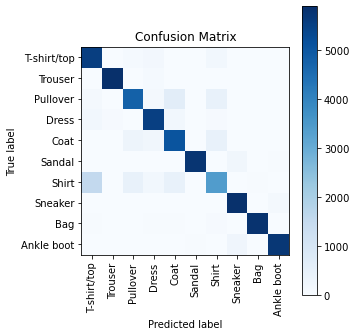

In [55]:
def plot_cm(cm, classes):
    plt.figure(figsize=(5,5))
    plt.title('Confusion Matrix')
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=90)
    plt.yticks(np.arange(len(classes)), classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

plot_cm(cm, train_set.classes)